In [37]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_data_transformation import colors_iterator
from DS_models_stat import cut_cat
from DS_Planck_Unet import val_pix
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
%config InlineBackend.figure_format = 'retina'

In [14]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = {os.path.splitext(os.path.basename(s))[0] : os.path.join(dirname, s) for s in true_cats}
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

In [22]:
def make_histogram(ax, counts_list, bins, label_list=None, coef_list=None, log=True):
    if coef_list is None:
        coef_list = [1] * len(counts_list)
    if label_list is None:
        label_list = [''] * len(counts_list)
    
    ci = colors_iterator()
    for i, counts in enumerate(counts_list):
         ax.hist(bins[:-1], bins, weights=counts * coef_list[i], 
                  histtype='step', log=log, label=label_list[i], color=next(ci))
    ax.legend()

In [55]:
def found_all_error_calculated(det_cat, true_cat, small_rads=[0, 400], big_rads=[1000, 1500], saving=None, n_bins=20, func_cat=None):
    
    def func(angle1, angle2, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')

        for i in tqdm(range(len(det_cat))):
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree

            count = np.count_nonzero(np.logical_and(angle1/3600 <= sep, sep < angle2/3600))
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

        return colored
    
    def square(rads):
        return np.pi * (rads[1] ** 2 - rads[0] ** 2)
    
    if not (func_cat is None):
        det_cat = func_cat(det_cat)
        true_cat = func_cat(true_cat)
    
    found = func(*small_rads, det_cat, true_cat)
    error = func(*big_rads, det_cat, true_cat)
    
    small_sq = square(small_rads)
    big_sq = square(big_rads)
    
    bins = np.arange(0, 1 + 1/n_bins, 1/n_bins)
    
    found_counts, _ = np.histogram(found, bins)
    error_counts, _ = np.histogram(error, bins)
    all_counts, _ = np.histogram(det_cat['max_pred'], bins)
    
    return bins, found_counts / small_sq, error_counts / big_sq, all_counts, small_sq

In [56]:
bins, found, error, alls, found_coef = found_all_error_calculated(pd.read_csv(det_cat), pd.read_csv(true_cats['PSZ2']))
                                                      #func_cat=lambda x:cut_cat(x, big_pix=val_pix))

<ipython-input-63-84c58b6565f6>:5: RuntimeWarning: invalid value encountered in true_divide
  make_histogram(ax, [np.nan_to_num(error/found), np.nan_to_num(found * found_coef / alls)], bins,


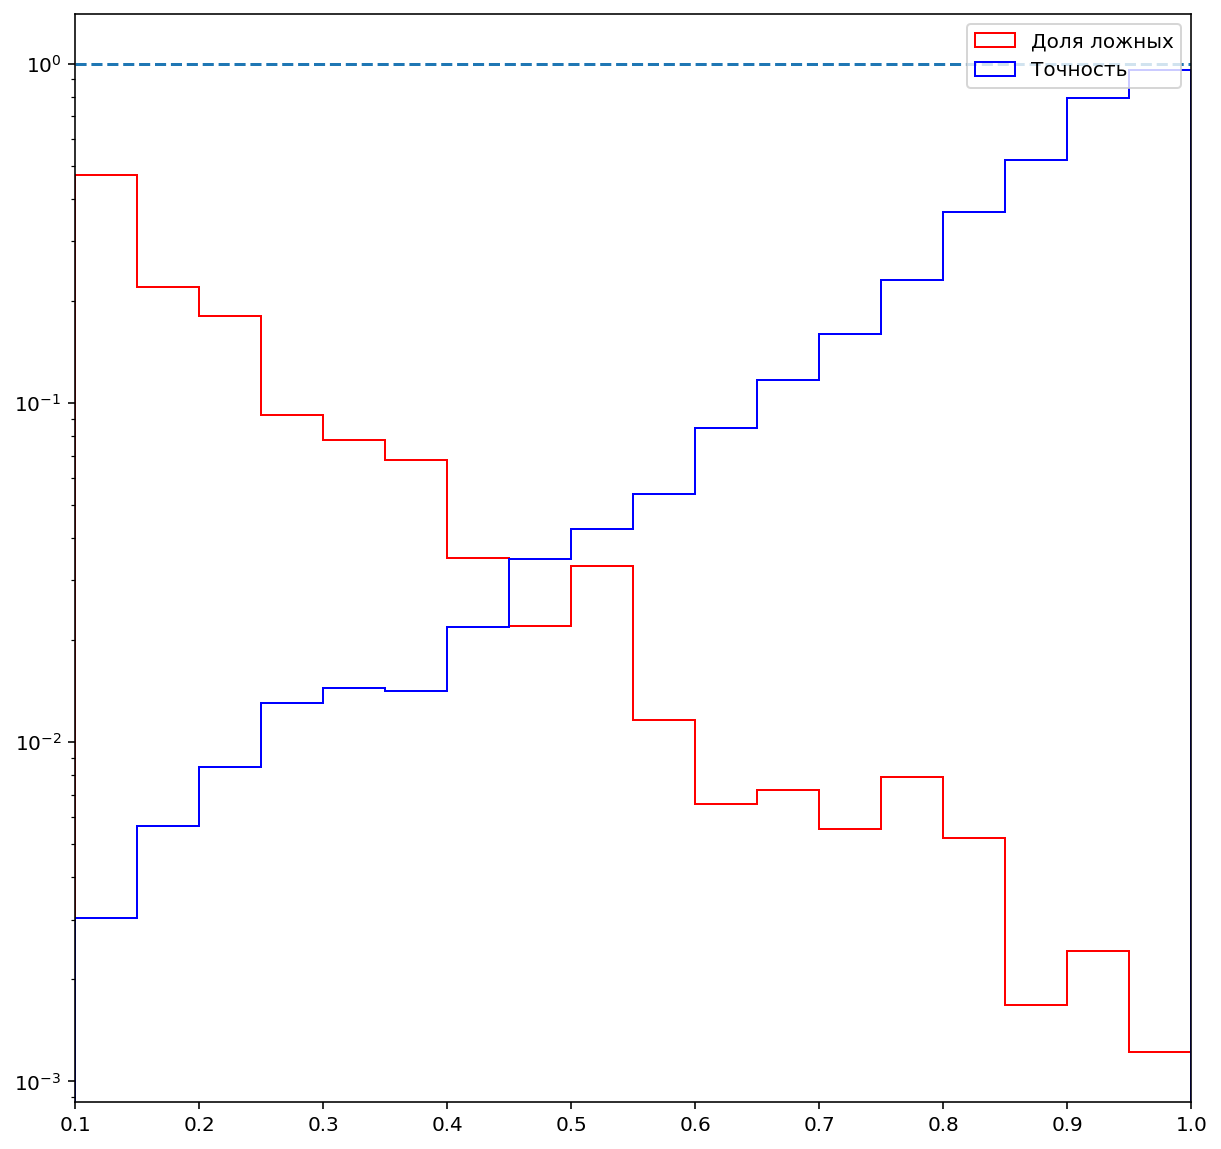

In [63]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim([0.1, 1])
ax.axhline(1, linestyle='--')
#ax.set_ylim([1, 10**4])
make_histogram(ax, [np.nan_to_num(error/found), np.nan_to_num(found * found_coef / alls)], bins, 
               label_list=['Доля ложных', 'Точность'])